# 실습: Seq2Seq, Attention_Model를 활용한 한영 번역

In [1]:
# -*- coding: utf-8 -*-

import time
import math
import unicodedata
import string
import re
import random
import codecs
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
%matplotlib inline

from torch.autograd import Variable
from torch import optim
from __future__ import unicode_literals

### matplotlib 한글폰트 설정

In [2]:
# print(fm.get_fontconfig_fonts())

font_location = "/usr/share/fonts/truetype/Naum/NanumGothic.ttf"
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

## help functions

In [3]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

## 데이터

In [4]:
DATA_PATH = "/home/ubuntu/practical-pytorch/data/"

In [5]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s) #한글을 출력을 위해 임시주석처리
    return s

In [6]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2 # Count SOS and EOS
      
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [7]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = codecs.open(DATA_PATH + "kor.txt", encoding="utf-8").read().strip().split('\n')
    print(">>")
    print (lines[0])
    
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    
    print (pairs[0])
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        
    return input_lang, output_lang, pairs

In [8]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [9]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('kor', 'eng', True)
print(random.choice(pairs))

Reading lines...
>>
Hello!	안녕!
['hello !', '안녕 !']
Read 489 sentence pairs
Trimmed to 7 sentence pairs
Counting words...
Counted words:
eng 23
kor 29
['걔 괜찮아 .', 'he is nice .']


# Preparing Training Data

- input tensor: indexes of the words in the input sentence
- target tensor: indexes of the words in the target sentence
- EOS token 붙임

In [10]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return Variable(torch.LongTensor(indexes).view(-1, 1))

def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

# The Seq2Seq Model


![](images/seq2seq.png)

## The Encoder

![](images/encoder-network.png)

In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, 1, self.hidden_size))

## The Decoder

### Simple Decoder

![](images/decoder-network.png)

In [12]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
        
    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, 1, self.hidden_size))

### Attention Decoder

![](https://i.imgur.com/1152PYf.png)


![](images/attention-decoder-network.png)

In [13]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, hidden, encoder_output, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]))
        return output, hidden, attn_weights

    def initHidden(self):
        return Variable(torch.zeros(1, 1, self.hidden_size))

## 학습을 위한 함수
- 타이머 작동
- 초기화: optimizers and criterion
- 학습 데이터 전처리
- 손실 함수

In [14]:
teacher_forcing_ratio = 0.5

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_output, encoder_outputs)
            loss += criterion(decoder_output[0], target_variable[di])
            decoder_input = target_variable[di] # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_output, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            decoder_input = Variable(torch.LongTensor([[ni]]))
            loss += criterion(decoder_output[0], target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0] / target_length

In [15]:
def trainEpochs(encoder, decoder, n_epochs, print_every=1000, plot_every=100, learning_rate=0.5):
    start = time.time()
    plot_losses = []
    print_loss_total = 0 # Reset every print_every
    plot_loss_total = 0 # Reset every plot_every
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs)) for i in range(n_epochs)]
    criterion = nn.NLLLoss()
    
    for epoch in range(1, n_epochs + 1):
        training_pair = training_pairs[epoch - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]
        loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg))
        
        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    showPlot(plot_losses)

## 결과 시각화를 위한 함수

In [16]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # this locator puts ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## 평가를 위한 함수

In [17]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [18]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()
    
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]])) # SOS
    decoder_hidden = encoder_hidden
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_output, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])
        decoder_input = Variable(torch.LongTensor([[ni]]))
    
    return decoded_words, decoder_attentions[:di+1]

# 학습

0m 29s (- 24m 12s) (1000 2%) 87.4060
1m 0s (- 24m 19s) (2000 4%) 72.4886
1m 28s (- 23m 5s) (3000 6%) 66.8288
1m 57s (- 22m 35s) (4000 8%) 59.4884
2m 24s (- 21m 37s) (5000 10%) 66.4815
2m 56s (- 21m 31s) (6000 12%) 62.4051
3m 26s (- 21m 8s) (7000 14%) 62.7388
3m 58s (- 20m 53s) (8000 16%) 63.0111
4m 29s (- 20m 27s) (9000 18%) 57.5700
4m 57s (- 19m 50s) (10000 20%) 56.2479
5m 27s (- 19m 21s) (11000 22%) 53.8093
5m 58s (- 18m 55s) (12000 24%) 53.8028
6m 30s (- 18m 30s) (13000 26%) 52.2731
7m 0s (- 18m 0s) (14000 28%) 52.0917
7m 31s (- 17m 34s) (15000 30%) 50.2633
8m 3s (- 17m 7s) (16000 32%) 51.8240
8m 35s (- 16m 39s) (17000 34%) 72.0025
9m 6s (- 16m 10s) (18000 36%) 43.9463
9m 37s (- 15m 42s) (19000 38%) 36.6430
10m 10s (- 15m 15s) (20000 40%) 35.5829
10m 40s (- 14m 44s) (21000 42%) 35.5672
11m 11s (- 14m 14s) (22000 44%) 32.8331
11m 43s (- 13m 46s) (23000 46%) 36.0318
12m 15s (- 13m 16s) (24000 48%) 57.5020
12m 46s (- 12m 46s) (25000 50%) 39.0354
13m 15s (- 12m 14s) (26000 52%) 39.2874


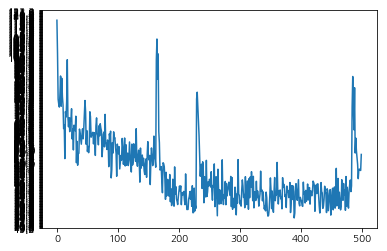

In [26]:
hidden_size = 128
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, 1, dropout_p=0.1)
trainEpochs(encoder1, attn_decoder1, 50000, print_every=1000)

In [27]:
evaluateRandomly(encoder1, attn_decoder1)

> 그는 학급에서 가장 둔한 아이이다 .
= he is the dumbest kid in the class .
< he is kid class kid class kid class kid class

> 나는 임신 4개월이다 .
= i am four months pregnant .
< she beautiful than beautiful beautiful than beautiful beautiful than beautiful

> 그녀는 꽃을 좋아한다고 말했다 .
= she says she likes flowers .
< she says she likes beautiful likes beautiful flowers beautiful flowers

> 아름다우시네요 .
= you are beautiful .
< you are beautiful says she likes beautiful flowers beautiful flowers

> 그녀는 누구보다도 아름다워요 .
= she is more beautiful than any other girl .
< she beautiful beautiful beautiful beautiful beautiful beautiful beautiful beautiful beautiful

> 걔 괜찮아 .
= he is nice .
< he is kid class kid kid class kid class kid

> 나 향수병 걸렸어 .
= i am homesick .
< i am homesick beautiful . <EOS>

> 그녀는 누구보다도 아름다워요 .
= she is more beautiful than any other girl .
< she beautiful other beautiful beautiful other beauti

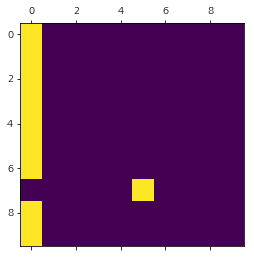

In [28]:
output_words, attentions = evaluate(encoder1, attn_decoder1, "그녀는 누구보다도 아름다워요 .")
plt.matshow(attentions.numpy())

In [29]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

input = 그녀는 누구보다도 아름다워요 .
output = she beautiful beautiful other beautiful other beautiful beautiful other beautiful


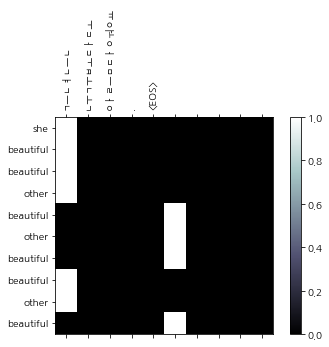

In [30]:
evaluateAndShowAttention("그녀는 누구보다도 아름다워요 .")